<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/DENOISED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas_ta

In [3]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM

In [4]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']
change = df['ACh']
print(df)

             Date   Time       BO       BH       BL       BC      BCh  \
0      2005-05-02  00:00  1.28520  1.28520  1.28400  1.28440 -0.00080   
1      2005-05-02  01:00  1.28440  1.28480  1.28390  1.28420 -0.00020   
2      2005-05-02  02:00  1.28430  1.28540  1.28410  1.28510  0.00080   
3      2005-05-02  03:00  1.28510  1.28590  1.28500  1.28510  0.00000   
4      2005-05-02  04:00  1.28520  1.28590  1.28490  1.28550  0.00030   
...           ...    ...      ...      ...      ...      ...      ...   
93079  2020-04-29  18:00  1.08620  1.08851  1.08611  1.08713  0.00093   
93080  2020-04-29  19:00  1.08711  1.08823  1.08659  1.08748  0.00037   
93081  2020-04-29  20:00  1.08747  1.08788  1.08691  1.08708 -0.00039   
93082  2020-04-29  21:00  1.08708  1.08740  1.08699  1.08714  0.00006   
93083  2020-04-29  22:00  1.08728  1.08760  1.08727  1.08743  0.00015   

            AO       AH       AL       AC      ACh  
0      1.28540  1.28540  1.28420  1.28460 -0.00080  
1      1.28460  1

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

Date_df = pd.DataFrame({
       'Month': df['Date'].dt.month / 12,  # Divide by 12 to normalize the values between 0 and 1
       'Day': df['Date'].dt.day / 31,  # Divide by 31 to normalize the values between 0 and 1
       'Hour': df['Time'].dt.hour / 24,  # Divide by 24 to normalize the values between 0 and 1
       'DayOfWeek': df['Date'].dt.dayofweek / 6  # Divide by 6 to normalize the values between 0 and 1
   })

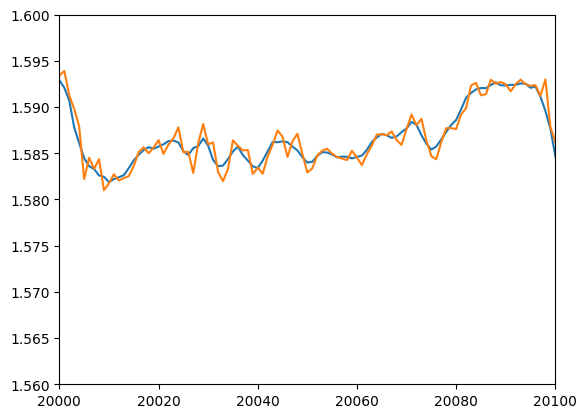

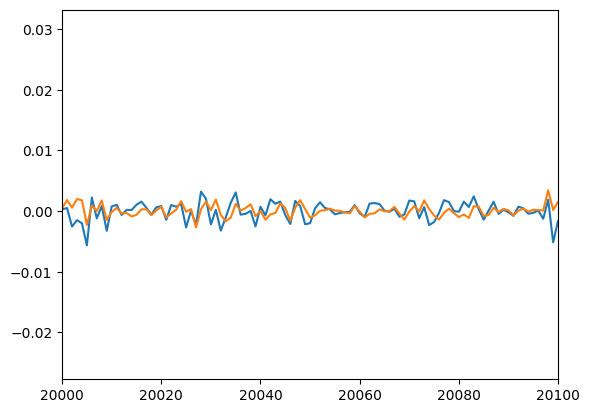

In [6]:
SMA = ta.sma(close,4,offset=-2)
NOISE = close-SMA
BAR_SIZE = high-low
OPEN_SIZE = open - low
CLOSE_SIZE = close - low

plt.xlim(20000,20100)
plt.ylim(1.56,1.6)
plt.plot(SMA)
plt.plot(close)
plt.show()
plt.xlim(20000,20100)
plt.plot(change)
plt.plot(NOISE)
plt.show()

In [7]:
# Define the window length and stride
window_length = 4
stride = 1

month = Date_df['Month']
day = Date_df['Day']
hour = Date_df['Hour']
dotw = Date_df['DayOfWeek']
changed = pd.Series(change,name='change')
NOISED = pd.Series(NOISE,name='noise')
combined_series = pd.concat([changed,NOISED,month,day,hour,dotw], axis=1)
combined_series = combined_series.dropna(axis=0)
print(combined_series)
noise = combined_series.pop('noise')
changed = combined_series.pop('change')
month = combined_series.pop('Month')
day = combined_series.pop('Day')
hour = combined_series.pop('Hour')
dotw = combined_series.pop('DayOfWeek')

# Create the sliding window view for time_series_1
changed = sliding_window_view(changed, window_length)[::stride]
NOISED = np.roll(noise, -window_length+1)
NOISED = NOISED[:changed.shape[0]]
month = np.expand_dims(month[:changed.shape[0]],1)
day = np.expand_dims(day[:changed.shape[0]],1)
hour = np.expand_dims(hour[:changed.shape[0]],1)
dotw = np.expand_dims(dotw[:changed.shape[0]],1)


changed = changed/np.std(changed)
NOISED = NOISED/np.std(NOISED)
print(changed)

        change     noise     Month       Day      Hour  DayOfWeek
1     -0.00020 -0.000500  0.416667  0.064516  0.041667   0.000000
2      0.00080  0.000125  0.416667  0.064516  0.083333   0.000000
3      0.00000 -0.000175  0.416667  0.064516  0.125000   0.000000
4      0.00030  0.000050  0.416667  0.064516  0.166667   0.000000
5      0.00000 -0.000150  0.416667  0.064516  0.208333   0.000000
...        ...       ...       ...       ...       ...        ...
93077 -0.00049 -0.001162  0.333333  0.935484  0.666667   0.333333
93078  0.00179  0.000037  0.333333  0.935484  0.708333   0.333333
93079  0.00066 -0.000130  0.333333  0.935484  0.750000   0.333333
93080  0.00035 -0.000050  0.333333  0.935484  0.791667   0.333333
93081  0.00050  0.000345  0.333333  0.935484  0.833333   0.333333

[93081 rows x 6 columns]
[[-0.12938645  0.51754578  0.          0.19407967]
 [ 0.51754578  0.          0.19407967  0.        ]
 [ 0.          0.19407967  0.          0.25877289]
 ...
 [ 0.03881593 -0.3169967

[0.19407967 0.         0.25877289 ... 0.42697527 0.22642628 0.32346611]
[ 0.05216151 -0.15648453  0.03912113 ... -0.13561992 -0.05216151
  0.35991441]


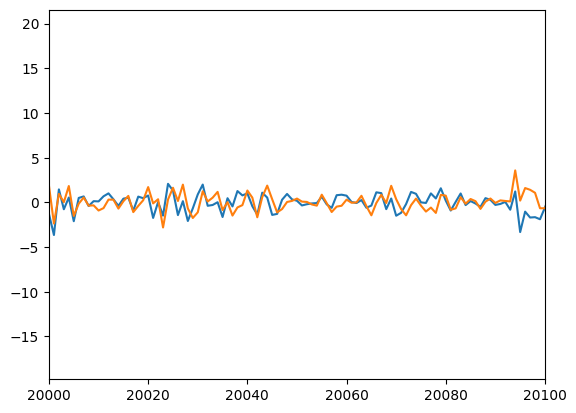

In [8]:

print(changed[:, -1])
print(NOISED)


plt.xlim(20000,20100)
plt.plot(changed[:, -1])
plt.plot(NOISED)


In [9]:
def activity_regularizer(multiplier, decay=0.99):
    # Initialize moving averages for mean and variance
    mean_avg = tf.Variable(0.0, trainable=False, name='mean_avg')
    variance_avg = tf.Variable(1.0, trainable=False, name='variance_avg')

    def regularizer(y_pred):
        # Calculate the current mean and variance
        current_mean = tf.reduce_mean(y_pred)
        current_variance = tf.math.reduce_variance(y_pred)

        # Update moving averages
        update_mean = tf.compat.v1.assign(mean_avg, decay * mean_avg + (1 - decay) * current_mean)
        update_variance = tf.compat.v1.assign(variance_avg, decay * variance_avg + (1 - decay) * current_variance)

        with tf.control_dependencies([update_mean, update_variance]):
            # Use the moving averages for regularization
            mean = mean_avg
            variance = variance_avg

        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))

    return regularizer

In [14]:
reg = activity_regularizer(.01)

# Create a sequential model
model = Sequential()


model.add(Dense(24, activation='gelu',activity_regularizer=reg))
model.add(Dense(24, activation='gelu',activity_regularizer=reg))
model.add(Dense(1, activation=None))

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [19]:
X_train=np.concatenate((changed,month,day,hour,dotw), axis=1)
y_train=NOISED

model.fit(X_train, y_train, epochs=100000, batch_size=64,validation_split=.2)

Epoch 1/100000
1164/1164 [==============================] - 2s 2ms/step - loss: 0.9514 - mae: 0.6278 - val_loss: 0.3466 - val_mae: 0.3876
Epoch 2/100000
1164/1164 [==============================] - 2s 2ms/step - loss: 0.9505 - mae: 0.6277 - val_loss: 0.3487 - val_mae: 0.3891
Epoch 3/100000
1164/1164 [==============================] - 4s 3ms/step - loss: 0.9511 - mae: 0.6279 - val_loss: 0.3476 - val_mae: 0.3887
Epoch 4/100000
1164/1164 [==============================] - 3s 3ms/step - loss: 0.9512 - mae: 0.6281 - val_loss: 0.3468 - val_mae: 0.3875
Epoch 5/100000
1164/1164 [==============================] - 2s 2ms/step - loss: 0.9505 - mae: 0.6276 - val_loss: 0.3471 - val_mae: 0.3879
Epoch 6/100000
1164/1164 [==============================] - 2s 2ms/step - loss: 0.9509 - mae: 0.6282 - val_loss: 0.3471 - val_mae: 0.3880
Epoch 7/100000
1164/1164 [==============================] - 2s 2ms/step - loss: 0.9510 - mae: 0.6277 - val_loss: 0.3469 - val_mae: 0.3875
Epoch 8/100000
1164/1164 [========

KeyboardInterrupt: ignored

In [20]:
prediction = model.predict(X_train)

2909/2909 [==============================] - 3s 1ms/step


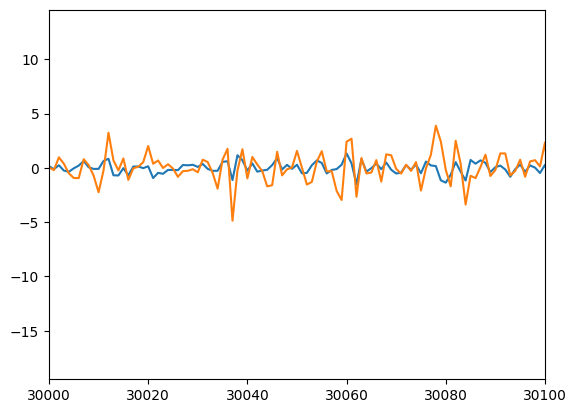

In [21]:
plt.xlim(30000,30100)
plt.plot(prediction)
plt.plot(y_train)

In [ ]:
# Set the print options
np.set_printoptions(suppress=True, precision=4)
print(model.get_weights())